In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
train_df = pd.read_csv('/kaggle/input/self-driving-structured-dataset/train_dataset.csv')
test_df = pd.read_csv('/kaggle/input/self-driving-structured-dataset/test_dataset.csv')
image_dir = '/kaggle/input/self-driving-structured-dataset/archive/driving_dataset/'

In [4]:
# 构建数据生成器
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)

In [5]:
train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col="Image",
    y_col="Angles",
    subset="training",
    batch_size=32,
    class_mode="raw",
    target_size=(32, 32),
    shuffle=True)

val_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col="Image",
    y_col="Angles",
    subset="validation",
    batch_size=32,
    class_mode="raw",
    target_size=(32, 32),
    shuffle=True)

Found 4000 validated image filenames.
Found 1000 validated image filenames.


In [6]:
model = Sequential([
    Input(shape=(32, 32, 3)),  
    Conv2D(32, (3, 3), padding='same'), Activation('relu'),
    Conv2D(32, (3, 3)), Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)), Dropout(0.25),

    Conv2D(64, (3, 3), padding='same'), Activation('relu'),
    Conv2D(64, (3, 3)), Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)), Dropout(0.25),

    Flatten(), Dense(512), Activation('relu'), Dropout(0.5),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mean_squared_error')


In [10]:
earlystop = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_gen, validation_data=val_gen, epochs=3, callbacks=[earlystop])

Epoch 1/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 4.0380 - val_loss: 4.5427
Epoch 2/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 4.5068 - val_loss: 1.1938
Epoch 3/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - loss: 3.8656 - val_loss: 1.6226


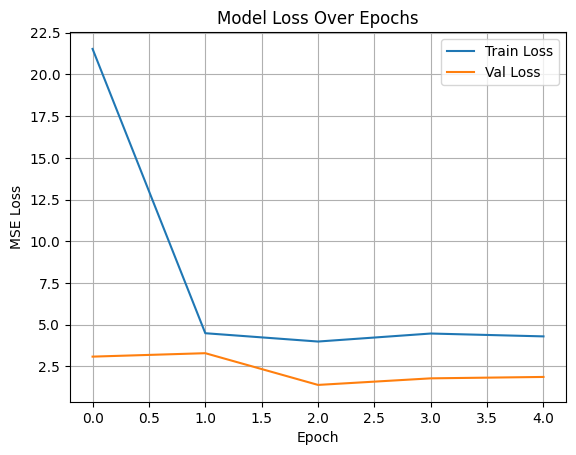

In [8]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# 预测测试集角度
test_datagen = ImageDataGenerator(rescale=1./255.)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col="Image",
    y_col=None,
    batch_size=32,
    class_mode=None,
    target_size=(32, 32),
    shuffle=False)
pred = model.predict(test_gen, verbose=1)

Found 1000 validated image filenames.
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step


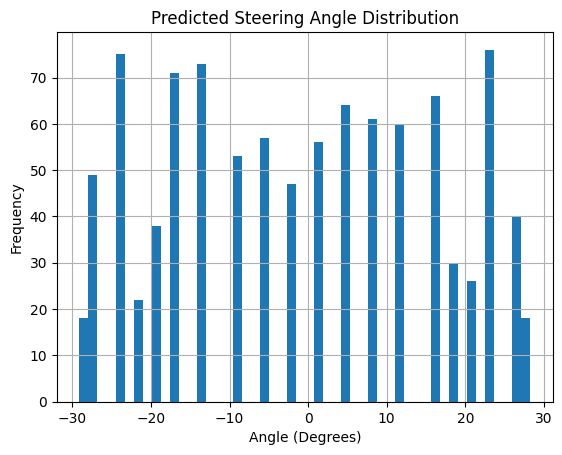

In [12]:
plt.hist(pred.flatten(), bins=50)
plt.title("Predicted Steering Angle Distribution")
plt.xlabel("Angle (Degrees)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [13]:
submission = test_df.copy()
submission["Angles"] = pred
submission.to_csv("/kaggle/working/submission.csv", index=False)